# Simple Collage Script

Using pillow and matplotlib


In [41]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from math import sqrt
from PIL import Image, ExifTags
import os
from pathlib import Path

In [45]:
# Settings

## depends on current display (monitor)
from math import hypot
physical_diagonal_in = 30
res_diagonal_px = hypot(2560, 1600)
ppi = res_diagonal_px / physical_diagonal_in

cell_space = 20
collage_width = 1200


In [61]:
def get_orientation_key():
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation] == 'Orientation':
            return orientation

orientation_key = get_orientation_key()

def process_image(image, final_image_height, final_image_width):
    # image.resize() seems to drop the exif metadata, so acquire it now
    exif = image._getexif()

    # check metadata to see if the image needs to be rotated
    if orientation_key in exif:
        if exif[orientation_key] == 3:
            image = image.rotate(180)

    # resize on the same factor to keep the aspect ratio
    # use the smallest factor, so we can crop later so we can use the exact
    # (image_width X image_height) dimension.
    factor = min(image.height / final_image_height, image.width / final_image_width) 
    image = image.resize(
        (int(image.width / factor), int(image.height / factor)),
    )    

    # crop the borders so the all images have the same dimensions
    height_slack = image.height - final_image_height
    offset_top = height_slack / 2.0
    width_slack = image.width - final_image_width
    offset_left = width_slack / 2.0
    
    image = image.crop((offset_left, offset_top, offset_left + final_image_width, offset_top + final_image_height))   
    
    return image

def is_image_file(filename):
    filename = Path(filename.lower())
    if filename.suffix in ['.jpg', '.png']:
        return True

    return False

def make_collage(
    directory, 
    nrows, 
    ncols, 
    # w / h
    aspect_ratio=None
):
    # first images from directory
    image_files = sorted([file for file in os.listdir(directory) if is_image_file(file)][:ncols * nrows])

    # use the aspect ratio of the first image
    if aspect_ratio is None:
        image = Image.open(directory + image_files[0])
        aspect_ratio = (image.width * ncols + cell_space * (ncols - 1)) / (image.height * nrows +  cell_space * (nrows - 1))
    
    collage_height = collage_width / aspect_ratio
        
    image_width = (collage_width - cell_space * (ncols - 1)) // ncols
    image_height = (collage_height - cell_space * (nrows - 1)) // nrows
    
    thumb_images = []
    for image_file in image_files:
        image = Image.open(directory + image_file)
        thumb_images.append(process_image(image, image_height, image_width))

    # matplotlib grid works with % of the dimensions, so
    # we need to do some math.
    gridspec_kw = {    
        'wspace': cell_space / collage_width,
        'hspace': cell_space / collage_height,
    }
    
    fig, axs = plt.subplots(
        nrows, 
        ncols, 
        figsize=(collage_width / ppi, collage_height / ppi), 
        gridspec_kw=gridspec_kw
    )

    # plt.subplots has this awful behavior in which it returns a scalar when
    # one of the dimensions is 1
    if nrows == 1:
        axs = [axs]
    if ncols == 1:
        for i in range(nrows):
            axs[i] = [axs[i]]            
            
    for r in range(nrows):
        for c in range(ncols):
            ax = axs[r][c]
            ax.imshow(thumb_images[r*ncols + c])
            ax.axis('off')

    plt.show()
    

def make_collage_retrospective(directory):
    make_collage(directory, 2, 3, aspect_ratio=2.0)


# Execution

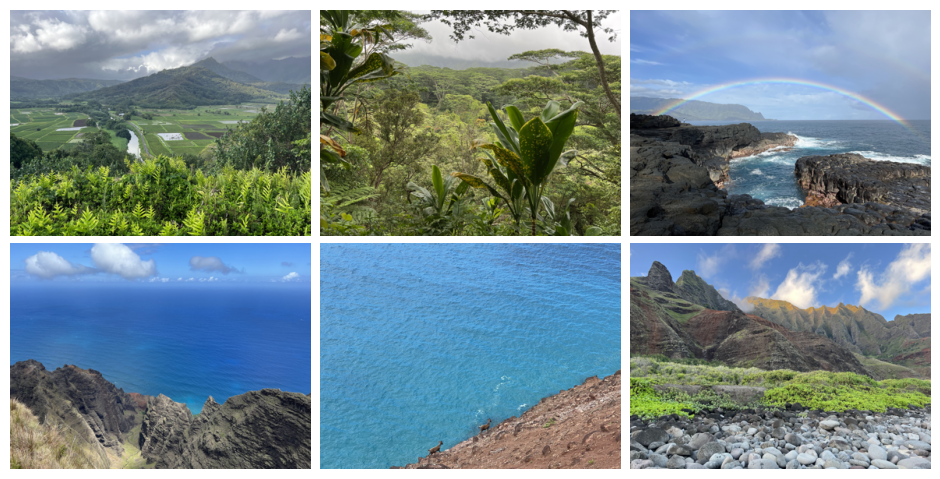

In [60]:
make_collage_retrospective('/Users/kunigami/Downloads/kauai/')

    

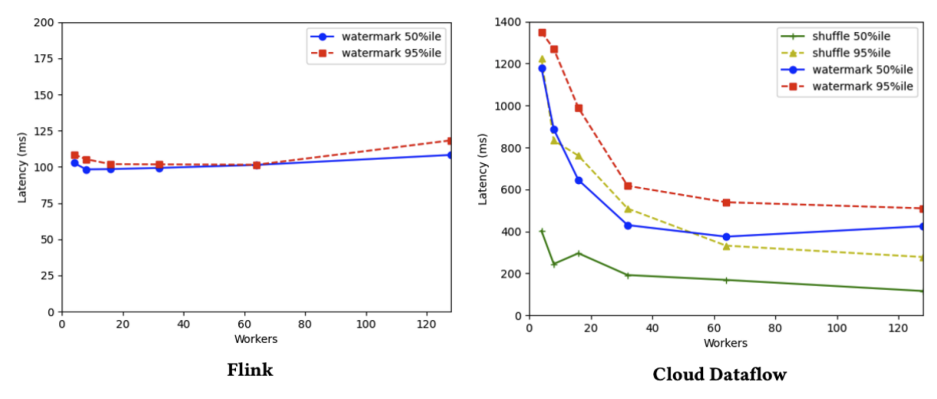

In [62]:
make_collage('/Users/kunigami/Desktop/graphs1/', 1, 2)


# References

* https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
* https://stackoverflow.com/questions/13872331/rotating-an-image-with-orientation-specified-in-exif-using-python-without-pil-in\
* https://pillow.readthedocs.io/en/stable/reference/Image.html